In [39]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
from utils import *

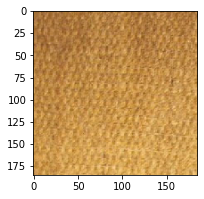

In [40]:
folder_path = "img/"

source = cv2.imread(folder_path + "tiling.png")
#let's plot the image to have a better understanding of the before and after
single_image(source)

In [41]:
def get_masked_values(values, mask):
    assert values.shape == mask.shape
    nonzero_idx = np.nonzero(mask) # get mask 1
    return values[nonzero_idx]

img_w, img_h = source.shape[:2]
mask = np.ones((img_h, img_w))
boundary_mask = np.ones((img_h, img_w))
boundary_mask[np.ix_(np.arange(1, img_h - 1), np.arange(1, img_w - 1))] = 0

inner_mask = mask - boundary_mask

pixel_ids = np.arange(mask.shape[0] * mask.shape[1]).reshape(mask.shape[0], mask.shape[1])
inner_ids = get_masked_values(pixel_ids, inner_mask).flatten()
boundary_ids = get_masked_values(pixel_ids, boundary_mask).flatten()
mask_ids = get_masked_values(pixel_ids, mask).flatten() # boundary + inner

inner_pos = np.searchsorted(mask_ids, inner_ids) 
boundary_pos = np.searchsorted(mask_ids, boundary_ids)
mask_pos = np.searchsorted(pixel_ids.flatten(), mask_ids)

In [42]:
def construct_A_matrix():
    A = scipy.sparse.lil_matrix((len(mask_ids), len(mask_ids)))

    n1_pos = np.searchsorted(mask_ids, inner_ids - 1)
    n2_pos = np.searchsorted(mask_ids, inner_ids + 1)
    n3_pos = np.searchsorted(mask_ids, inner_ids - img_w)
    n4_pos = np.searchsorted(mask_ids, inner_ids + img_w)

    A[inner_pos, n1_pos] = 1
    A[inner_pos, n2_pos] = 1
    A[inner_pos, n3_pos] = 1
    A[inner_pos, n4_pos] = 1
    A[inner_pos, inner_pos] = -4 

    A[boundary_pos, boundary_pos] = 1
    
    return A.tocsr()

(185, 185, 3)


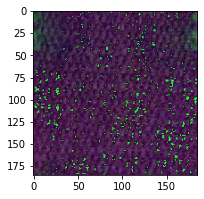

In [45]:
#poisson illumination changes
def poisson_illumination_change(source):
    # Calculate image dimensions
    height, width = source.shape
    src = source.copy()
    # Create a Laplacian matrix
    laplacian = construct_A_matrix()

    gradients = finite_full_gradient_xy_single(source)

    new_boundary = np.zeros_like(src)
    new_boundary[0] = (src[0] + src[-1]) * 0.5
    new_boundary[-1] = (src[0] + src[-1]) * 0.5
    new_boundary[:, 0] = (src[:, 0] + src[:, -1]) * 0.5
    new_boundary[:, -1] = (src[:, 0] + src[:, -1]) * 0.5
    #b[0, :] = b[-1, :] = (source[0, :] + source[-1, :]) / 2
    #b[:, 0] = b[:, -1] = (source[:, 0] + source[:, -1]) / 2
    #b[0, 0] = b[0, -1] = b[-1, 0] = b[-1, -1] = (source[0, 0] + source[0, -1] + source[-1, 0] + source[-1, -1]) // 4
    boundary_pixel_values = get_masked_values(new_boundary, boundary_mask).flatten()
    inner_gradient_values = get_masked_values(gradients, inner_mask).flatten()
    b = np.zeros(len(mask_ids))
    b[inner_pos] = inner_gradient_values
    b[boundary_pos] = boundary_pixel_values
    b = b.flatten()

    # Solve the linear system to get the blended image 
    blended_flat = spsolve(laplacian, b)

    # Clip pixel values to the [0, 255] range
    blended_flat = np.clip(blended_flat, 0, 255)

    # Reshape and update the target image with the blended channel
    target = blended_flat.reshape((height, width))

    return target

tmp = split_function_per_color(source, poisson_illumination_change, 3)
print(tmp.shape)
single_image(tmp)
#cv2.imwrite("tiling_test.png", split_function_per_color(source, poisson_illumination_change, 3))

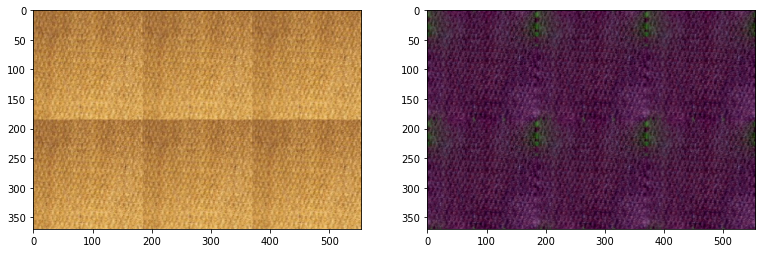

In [44]:
edited = cv2.imread("illumination_test.png")
source = cv2.imread(folder_path + "tiling.png")

oldtile = np.tile(source, (2, 3, 1))
newtile = np.tile(edited, (2, 3, 1))

fig = plt.figure(figsize=(20, 10))
plt.subplot(131)
plt.imshow(convert_image_color(oldtile))
plt.subplot(132)
plt.imshow(newtile)
